## Tugas Besar II IF3270 Pembelajaran Mesin - LSTM

### Anggota Kelompok:
1. Suthasoma Mahardhika Munthe (13522098)
2. Marvin Scifo Y. Hutahaean (13522110)
3. Berto Richardo Togatorop (13522118)

In [10]:
import numpy as np
import pandas as pd
from customnn import LSTM, Embedded, FullyConnected
from keras import layers
from keras import models

url_train = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/train.csv"
url_valid = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/valid.csv"
url_test = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/test.csv"

df_train = pd.read_csv(url_train)
df_valid = pd.read_csv(url_valid)
df_test = pd.read_csv(url_test)

In [11]:
max_tokens = 10000
output_sequence_length = 100

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
vectorizer.adapt(df_train['text'])
vectorizer_data = vectorizer(df_train['text'])
vectorizer_test = vectorizer(df_test['text'])
vectorizer_val = vectorizer(df_valid['text'])
vocabs = len(vectorizer.get_vocabulary())

y_train = df_train['label'].to_numpy()
y_test = df_test['label'].to_numpy()
y_valid = df_test['label'].to_numpy()

In [12]:
embedder = Embedded(vocabs, 100, embeddings_initializer='xavier')
embedded_vector = embedder.forward(vectorizer_data)

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_int = le.fit_transform(df_train['label'])
y_test_int = le.transform(df_test['label'])
y_valid_int = le.transform(df_valid['label'])

In [14]:
lstm_models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.LSTM(units=128, return_sequences=True),
    layers.LSTM(units=256),
    layers.Dense(units=vocabs, activation='softmax')
])

lstm_models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
lstm_models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = lstm_models.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.2482 - loss: 7.7305 - val_accuracy: 0.4400 - val_loss: 5.3560
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.3845 - loss: 4.4975 - val_accuracy: 0.4400 - val_loss: 1.7500
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.3664 - loss: 1.5630 - val_accuracy: 0.4400 - val_loss: 1.1113
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.3678 - loss: 1.1217 - val_accuracy: 0.3600 - val_loss: 1.1333
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.3503 - loss: 1.1445 - val_accuracy: 0.3600 - val_loss: 1.0638
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.3883 - loss: 1.0816 - val_accuracy: 0.4400 - val_loss: 1.0713
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.3615 - loss: 1.0884 - val_accuracy: 0.3600 - val_loss: 1.0767
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.4066 - loss: 1.0796 - val_accuracy: 0.4400 - val_loss:

In [15]:
embedding_weights = lstm_models.layers[0].get_weights()[0]
lstm_weights = lstm_models.layers[1].get_weights()
kernel, recurrent_kernel, bias_lstm = lstm_weights
lstm_weights_2 = lstm_models.layers[2].get_weights()
kernel_2, recurrent_kernel_2, bias_lstm_2 = lstm_weights_2
dense_weights = lstm_models.layers[3].get_weights()
kernel_dense, bias_dense = dense_weights

In [16]:
from sklearn.metrics import f1_score

class LSTMFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.lstm1 = LSTM(unit=128, input_size=100, timestep=100, return_sequence=True)
        self.lstm2 = LSTM(unit=256, input_size=128, timestep=100, return_sequence=False)
        self.fc1 = FullyConnected(input_size=256, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.lstm2.forward(self.lstm1.forward(self.embedding.forward(x))))
    
lstm_from_scratch = LSTMFromScratch(vocabs=vocabs)

lstm_from_scratch.embedding.weight = embedding_weights.copy()
lstm_from_scratch.lstm1.input_weights = kernel.copy()
lstm_from_scratch.lstm1.input_weights = np.split(lstm_from_scratch.lstm1.input_weights, 4, axis=1)
lstm_from_scratch.lstm1.hidden_weights = recurrent_kernel.copy()
lstm_from_scratch.lstm1.hidden_weights = np.split(lstm_from_scratch.lstm1.hidden_weights, 4, axis=1)
lstm_from_scratch.lstm1.bias = bias_lstm.copy()
lstm_from_scratch.lstm1.bias = np.split(lstm_from_scratch.lstm1.bias, 4)
lstm_from_scratch.lstm2.input_weights = kernel_2.copy()
lstm_from_scratch.lstm2.input_weights = np.split(lstm_from_scratch.lstm2.input_weights, 4, axis=1)
lstm_from_scratch.lstm2.hidden_weights = recurrent_kernel_2.copy()
lstm_from_scratch.lstm2.hidden_weights = np.split(lstm_from_scratch.lstm2.hidden_weights, 4, axis=1)
lstm_from_scratch.lstm2.bias = bias_lstm_2.copy()
lstm_from_scratch.lstm2.bias = np.split(lstm_from_scratch.lstm2.bias, 4)
lstm_from_scratch.fc1.weights = kernel_dense.copy()
lstm_from_scratch.fc1.biases = bias_dense.copy()

sample_input = vectorizer_data.numpy()

keras_output = lstm_models(sample_input, training=False).numpy()

outputs = []
for i in range(sample_input.shape[0]):
    x = sample_input[i]
    output = lstm_from_scratch.forward(x)
    outputs.append(output)

outputs = np.stack(outputs)

keras_labels = np.argmax(keras_output, axis=1)
scratch_labels = np.argmax(outputs, axis=1)

f1 = f1_score(keras_labels, scratch_labels, average='macro')

print("Difference:", np.abs(keras_output - outputs).mean())
print("F1:", f1)

Difference: 3.235865954784681e-08
F1: 1.0


In [17]:
bi_models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.Bidirectional(layers.LSTM(units=128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(units=256)),
    layers.Dense(units=vocabs, activation='softmax')
])
bi_models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
bi_models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = bi_models.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.2443 - loss: 7.4999 - val_accuracy: 0.4400 - val_loss: 3.1286
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.3707 - loss: 2.2308 - val_accuracy: 0.3600 - val_loss: 1.0820
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.3892 - loss: 1.1258 - val_accuracy: 0.4400 - val_loss: 1.0547
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.3688 - loss: 1.1184 - val_accuracy: 0.3600 - val_loss: 1.1020
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - accuracy: 0.3799 - loss: 1.0956 - val_accuracy: 0.3600 - val_loss: 1.0555
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.3541 - loss: 1.0908 - val_accuracy: 0.3600 - val_loss: 1.0849
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.3727 - loss: 1.0986 - val_accuracy: 0.4400 - val_loss: 1.0510
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - accuracy: 0.3952 - loss: 1.0821 - val_accuracy: 0.3600 - val_loss:

In [18]:
bi_embedding_weights = bi_models.layers[0].get_weights()[0]
bi_lstm_weights = bi_models.layers[1].get_weights()
bi_kernel, bi_recurrent_kernel, bi_bias_lstm, bi_kernel_reverse, bi_recurrent_kernel_reverse, bi_bias_lstm_reverse = bi_lstm_weights
bi_lstm_weights_2 = bi_models.layers[2].get_weights()
bi_kernel_2, bi_recurrent_kernel_2, bi_bias_lstm_2, bi_kernel_reverse_2, bi_recurrent_kernel_reverse_2, bi_bias_lstm_reverse_2 = bi_lstm_weights_2
bi_dense_weights = bi_models.layers[3].get_weights()
bi_kernel_dense, bi_bias_dense = bi_dense_weights

In [ ]:
class BiLSTMFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.lstm1 = LSTM(unit=128, input_size=100, timestep=100, return_sequence=True, bidirectional=True)
        self.lstm2 = LSTM(unit=256, input_size=256, timestep=100, return_sequence=False, bidirectional=True)
        self.fc1 = FullyConnected(input_size=512, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.lstm2.forward(self.lstm1.forward(self.embedding.forward(x))))
    
bi_lstm_from_scratch = BiLSTMFromScratch(vocabs=vocabs)

bi_lstm_from_scratch.embedding.weight = bi_embedding_weights.copy()

bi_lstm_from_scratch.lstm1.input_weights = bi_kernel.copy()
bi_lstm_from_scratch.lstm1.input_weights = np.split(bi_lstm_from_scratch.lstm1.input_weights, 4, axis=1)
bi_lstm_from_scratch.lstm1.hidden_weights = bi_recurrent_kernel.copy()
bi_lstm_from_scratch.lstm1.hidden_weights = np.split(bi_lstm_from_scratch.lstm1.hidden_weights, 4, axis=1)
bi_lstm_from_scratch.lstm1.bias = bi_bias_lstm.copy()
bi_lstm_from_scratch.lstm1.bias = np.split(bi_lstm_from_scratch.lstm1.bias, 4)
bi_lstm_from_scratch.lstm1.input_weights_reverse = bi_kernel_reverse.copy()
bi_lstm_from_scratch.lstm1.input_weights_reverse = np.split(bi_lstm_from_scratch.lstm1.input_weights_reverse, 4, axis=1)
bi_lstm_from_scratch.lstm1.hidden_weights_reverse = bi_recurrent_kernel_reverse.copy()
bi_lstm_from_scratch.lstm1.hidden_weights_reverse = np.split(bi_lstm_from_scratch.lstm1.hidden_weights_reverse, 4, axis=1)
bi_lstm_from_scratch.lstm1.bias_reverse = bi_bias_lstm_reverse.copy()
bi_lstm_from_scratch.lstm1.bias_reverse = np.split(bi_lstm_from_scratch.lstm1.bias_reverse, 4)

bi_lstm_from_scratch.lstm2.input_weights = bi_kernel_2.copy()
bi_lstm_from_scratch.lstm2.input_weights = np.split(bi_lstm_from_scratch.lstm2.input_weights, 4, axis=1)
bi_lstm_from_scratch.lstm2.hidden_weights = bi_recurrent_kernel_2.copy()
bi_lstm_from_scratch.lstm2.hidden_weights = np.split(bi_lstm_from_scratch.lstm2.hidden_weights, 4, axis=1)
bi_lstm_from_scratch.lstm2.bias = bi_bias_lstm_2.copy()
bi_lstm_from_scratch.lstm2.bias = np.split(bi_lstm_from_scratch.lstm2.bias, 4)
bi_lstm_from_scratch.lstm2.input_weights_reverse = bi_kernel_reverse_2.copy()
bi_lstm_from_scratch.lstm2.input_weights_reverse = np.split(bi_lstm_from_scratch.lstm2.input_weights_reverse, 4, axis=1)
bi_lstm_from_scratch.lstm2.hidden_weights_reverse = bi_recurrent_kernel_reverse_2.copy()
bi_lstm_from_scratch.lstm2.hidden_weights_reverse = np.split(bi_lstm_from_scratch.lstm2.hidden_weights_reverse, 4, axis=1)
bi_lstm_from_scratch.lstm2.bias_reverse = bi_bias_lstm_reverse_2.copy()
bi_lstm_from_scratch.lstm2.bias_reverse = np.split(bi_lstm_from_scratch.lstm2.bias_reverse, 4)

bi_lstm_from_scratch.fc1.weights = bi_kernel_dense.copy()
bi_lstm_from_scratch.fc1.biases = bi_bias_dense.copy()

bi_sample_input = vectorizer_data.numpy()

bi_keras_output = bi_models(bi_sample_input, training=False).numpy()

bi_outputs = []
for i in range(bi_sample_input.shape[0]):
    x = bi_sample_input[i]
    bi_output = bi_lstm_from_scratch.forward(x)
    bi_outputs.append(bi_output)

bi_outputs = np.stack(bi_outputs)

bi_keras_labels = np.argmax(bi_keras_output, axis=1)
bi_scratch_labels = np.argmax(bi_outputs, axis=1)

bi_f1 = f1_score(bi_keras_labels, bi_scratch_labels, average='macro')

print("Difference:", np.abs(bi_keras_output - bi_outputs).mean())
print("F1:",bi_f1)

Difference: 5.56358561754157e-06
F1: 0.8480286738351255


In [28]:
# LSTM Models Hyperparameter Analysis
lstm_models = [
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64, return_sequences=True),
        layers.LSTM(units=128),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64, return_sequences=True),
        layers.LSTM(units=128, return_sequences=True),
        layers.LSTM(units=256),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=32),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=128),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.Bidirectional(layers.LSTM(units=64)),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
]

In [29]:
name_layers = [
    "1 Layer",
    "2 Layers",
    "3 Layers",
    "32 Cells",
    "64 Cells",
    "128 Cells",
    "Unidirectional",
    "Bidirectional"
]

1 Layer
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.1617 - loss: 7.9244 - val_accuracy: 0.4400 - val_loss: 7.7085
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3695 - loss: 7.5629 - val_accuracy: 0.4400 - val_loss: 6.9216
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3360 - loss: 6.7472 - val_accuracy: 0.4400 - val_loss: 5.9303
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3836 - loss: 5.6837 - val_accuracy: 0.4400 - val_loss: 4.6806
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3589 - loss: 4.4379 - val_accuracy: 0.4400 - val_loss: 3.4122
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3748 - loss: 3.1940 - val_accuracy: 0.4400 - val_loss: 2.3759
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3805 - loss: 2.2439 - val_accuracy: 0.4400 - val_loss: 1.7076
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3532 - loss: 1.6877 - val_accuracy: 0.4400 - val_loss:

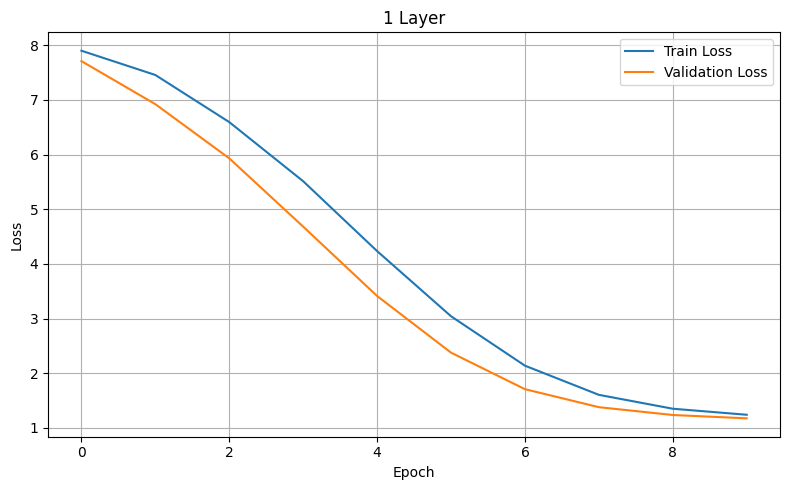


2 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.2453 - loss: 7.8492 - val_accuracy: 0.4400 - val_loss: 6.8143
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.3689 - loss: 6.3770 - val_accuracy: 0.4400 - val_loss: 4.7734
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.3919 - loss: 4.2677 - val_accuracy: 0.4400 - val_loss: 2.5785
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4145 - loss: 2.2342 - val_accuracy: 0.4400 - val_loss: 1.4150
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.3845 - loss: 1.3401 - val_accuracy: 0.3600 - val_loss: 1.1587
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.3648 - loss: 1.1549 - val_accuracy: 0.3600 - val_loss: 1.1000
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.3735 - loss: 1.1138 - val_accuracy: 0.3600 - val_loss: 1.0798
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3730 - loss: 1.1030 - val_accuracy: 0.3600 - v

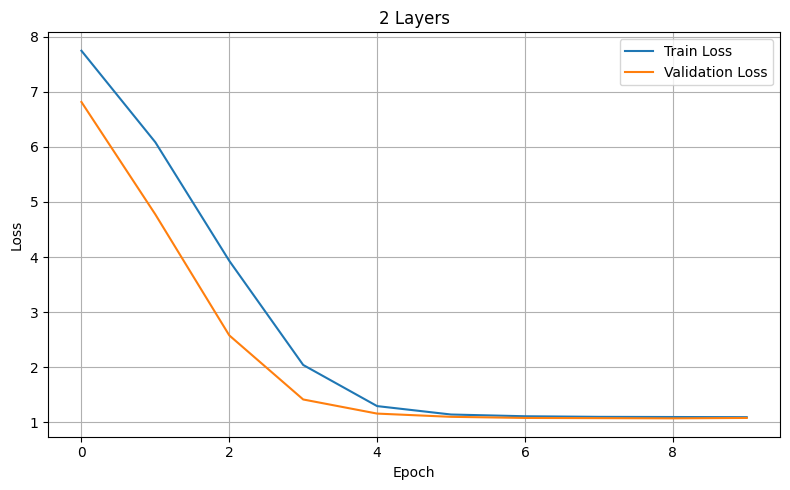


3 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.2286 - loss: 7.6076 - val_accuracy: 0.4400 - val_loss: 4.8861
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.3779 - loss: 3.9827 - val_accuracy: 0.4400 - val_loss: 1.5040
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.3867 - loss: 1.3640 - val_accuracy: 0.4400 - val_loss: 1.0853
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.4265 - loss: 1.0953 - val_accuracy: 0.3600 - val_loss: 1.1251
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.3779 - loss: 1.1100 - val_accuracy: 0.4400 - val_loss: 1.0610
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.3932 - loss: 1.0908 - val_accuracy: 0.4400 - val_loss: 1.0554
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.3867 - loss: 1.0923 - val_accuracy: 0.3600 - val_loss: 1.0735
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.3877 - loss: 1.0854 - val_accuracy: 0.3600 -

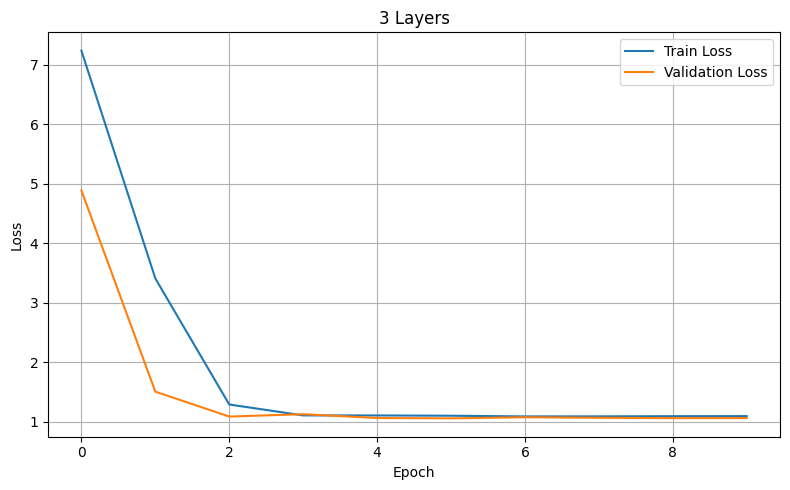


32 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.1025 - loss: 7.9276 - val_accuracy: 0.3600 - val_loss: 7.8084
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4001 - loss: 7.7299 - val_accuracy: 0.3600 - val_loss: 7.4211
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3969 - loss: 7.3011 - val_accuracy: 0.3600 - val_loss: 6.9235
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4148 - loss: 6.7733 - val_accuracy: 0.3600 - val_loss: 6.3264
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3752 - loss: 6.1585 - val_accuracy: 0.3600 - val_loss: 5.6332
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3651 - loss: 5.4653 - val_accuracy: 0.3600 - val_loss: 4.9400
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3692 - loss: 4.7811 - val_accuracy: 0.3600 - val_loss: 4.3035
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4076 - loss: 4.1421 - val_accuracy: 0.3600 - val_los

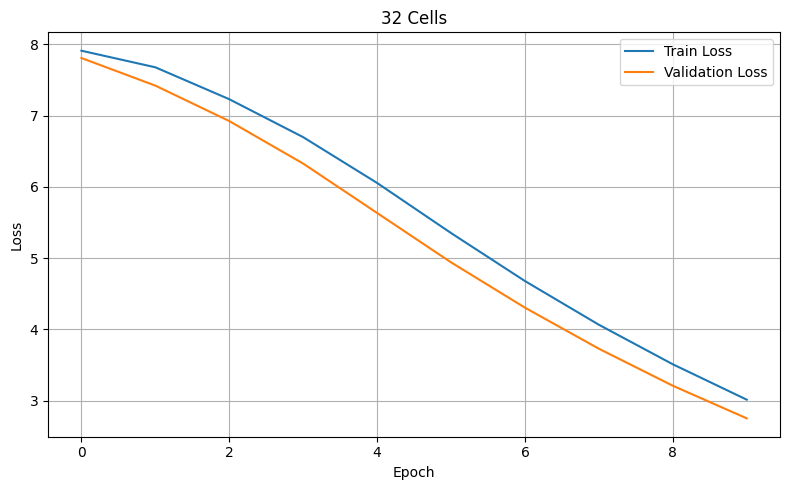


64 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.1679 - loss: 7.9158 - val_accuracy: 0.3600 - val_loss: 7.6636
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3982 - loss: 7.4847 - val_accuracy: 0.3600 - val_loss: 6.7686
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3813 - loss: 6.5432 - val_accuracy: 0.3600 - val_loss: 5.7017
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3790 - loss: 5.4199 - val_accuracy: 0.3600 - val_loss: 4.4208
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3976 - loss: 4.1313 - val_accuracy: 0.3600 - val_loss: 3.1970
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3793 - loss: 2.9646 - val_accuracy: 0.3600 - val_loss: 2.2486
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3996 - loss: 2.0877 - val_accuracy: 0.3600 - val_loss: 1.6562
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3733 - loss: 1.5918 - val_accuracy: 0.3600 - val_los

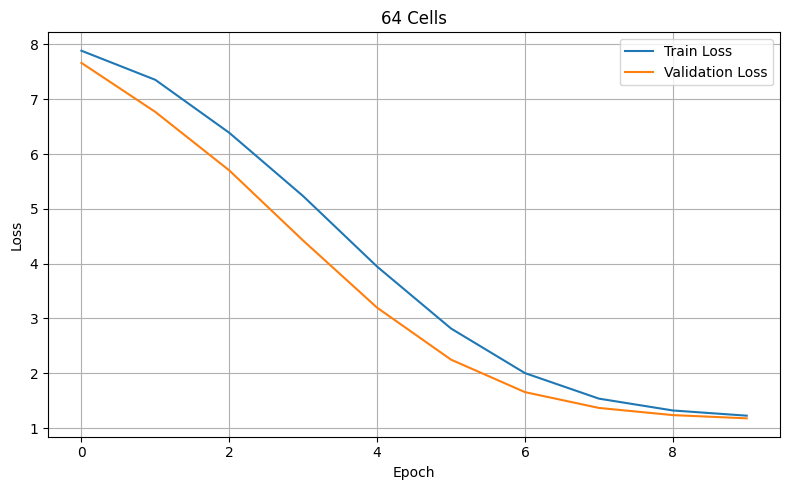


128 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.2519 - loss: 7.8682 - val_accuracy: 0.3600 - val_loss: 6.9945
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3612 - loss: 6.5160 - val_accuracy: 0.3600 - val_loss: 4.9386
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3878 - loss: 4.4205 - val_accuracy: 0.3600 - val_loss: 2.7023
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4027 - loss: 2.3177 - val_accuracy: 0.3600 - val_loss: 1.4307
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3507 - loss: 1.3544 - val_accuracy: 0.3600 - val_loss: 1.1494
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3720 - loss: 1.1490 - val_accuracy: 0.3600 - val_loss: 1.0929
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3862 - loss: 1.1112 - val_accuracy: 0.3600 - val_loss: 1.0812
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3821 - loss: 1.1049 - val_accuracy: 0.4400 - val_lo

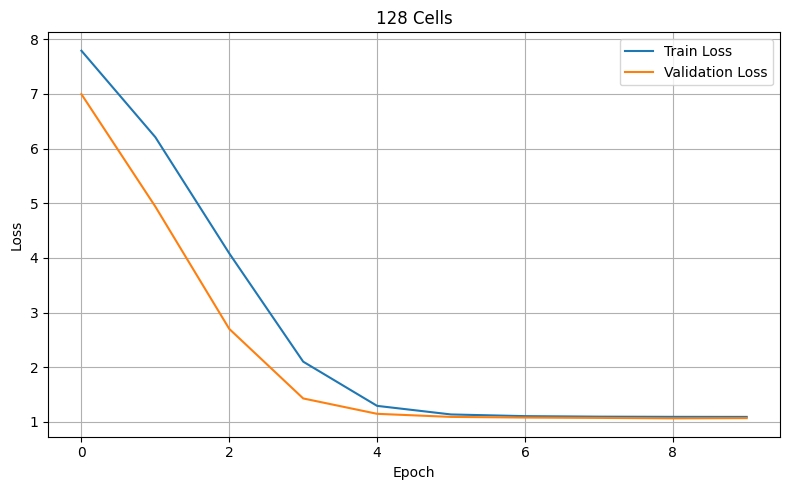


Unidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1624 - loss: 7.9107 - val_accuracy: 0.4400 - val_loss: 7.6306
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3505 - loss: 7.4502 - val_accuracy: 0.3600 - val_loss: 6.7404
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3867 - loss: 6.5029 - val_accuracy: 0.3600 - val_loss: 5.6460
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3849 - loss: 5.3547 - val_accuracy: 0.3600 - val_loss: 4.3442
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4001 - loss: 4.0467 - val_accuracy: 0.3600 - val_loss: 3.1144
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3799 - loss: 2.8839 - val_accuracy: 0.3600 - val_loss: 2.1830
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3750 - loss: 2.0344 - val_accuracy: 0.3600 - val_loss: 1.6231
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3927 - loss: 1.5515 - val_accuracy: 0.3600 - v

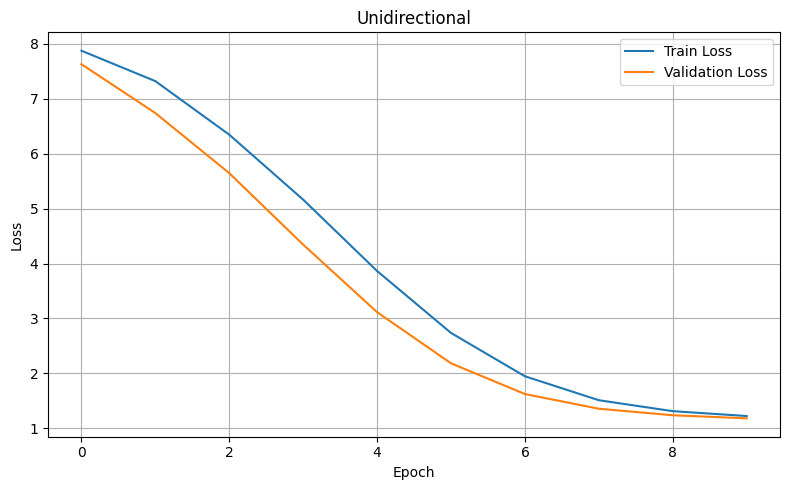


Bidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.2368 - loss: 7.9178 - val_accuracy: 0.4400 - val_loss: 7.6652
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3803 - loss: 7.4577 - val_accuracy: 0.4500 - val_loss: 6.3977
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3648 - loss: 5.9619 - val_accuracy: 0.2000 - val_loss: 4.3926
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3460 - loss: 3.9291 - val_accuracy: 0.4400 - val_loss: 2.3857
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3893 - loss: 2.0911 - val_accuracy: 0.4400 - val_loss: 1.3643
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3696 - loss: 1.3183 - val_accuracy: 0.4400 - val_loss: 1.1253
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3516 - loss: 1.1367 - val_accuracy: 0.3600 - val_loss: 1.0657
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3732 - loss: 1.0805 - val_accuracy: 0.3600 - va

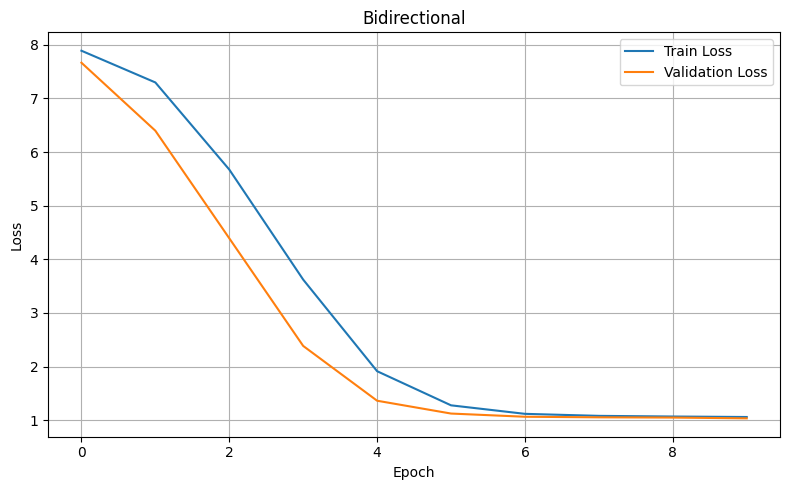

In [30]:
import matplotlib.pyplot as plt

n = 0

for model in lstm_models:
    print(name_layers[n])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    history = model.fit(
        vectorizer_data, y_train_int,
        epochs=10,
        batch_size=64,
        validation_split=0.2
    )
    test_loss, test_acc = model.evaluate(vectorizer_val, y_valid_int)

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name_layers[n])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    n += 1
    print()

